# 한국어 수화 해석하는 서비스 만들기 



# 필요한 라이브러리 설치 및 import 
1. Import and Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc
import time
import mediapipe as mp
import cv2
import os

In [ ]:
#GPU를 사용하는 tensorflow와 mediapipe 설치 

#mediapipe란 ? 주로 멀티 모달 오디오, 비디오 또는 모든 시계열 데이터를 구축하는 데 사용되는 프레임 워크입니다.

#using tensorflow with GPU, mediapipe detacting movements
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

# MP Holistic을 사용하여 pose, face, righthand, lefthand에 대한 <br>key point 생성하기 
2. Keypoints using MP Holistic


In [ ]:
mp_holistic = mp.solutions.holistic 
#mp.solutions.holistic 이란 ? -> 실시간 모션인식 (얼굴,몸의 분절을 실시간으로 추적한다.)

#Live perception of simultaneous human pose, face landmarks, 
#and hand tracking in real-time on mobile devices can enable various modern life applications
#https://google.github.io/mediapipe/solutions/holistic.html



mp_drawing = mp.solutions.drawing_utils # Drawing utilities
# 점을 연결하여 선을 보여준다.

In [ ]:
# 이미지를 추적하는 함수 만들기 
#이미지 -> RGB형식으로 만들어 모델에 대입한 결과를 results에 담고, 원상태로 만든 이미지와 results를 출력한다. 

def mediapipe_detection(image, model):   # 대상을 추적한다. 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction 모델에 대입 
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [ ]:
# 동영상에 점 찍기 

def draw_landmarks(image, results):  # 동영상의 frame과 동영상에서 받은 result를 받는다. 
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # 얼굴의 점을 연결하여 그린다.
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # POSE를 연결햐여 그린다.
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # 왼손 그리기
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # 오른손 그리기 

In [ ]:
# 더 정확한 판단을 위해 각각의 노드에 두개의 점을 추가한다. 
#add aditional 2 spots to the image

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),  
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# 3. Keypoint 값을 넘파이 형태로 추출하기 
3. Extract Keypoint Values

results.pose_landmarks.landmark -> [res.x, res.y, res.z, res.visibility]으로 구성 <br>
그외는 <br>
results.face_landmarks.landmark -> [res.x, res.y, res.z]으로 구성 


In [ ]:
## 위에서 만든 코드를 함수로 만들기 

# pose, face, lh, rh의 순서로 저장한다. 
# np.concatenate 를 하여 넘파이 배열을 하나로 합친다. 

###위의 코드를 간단하게 하고 pose, face, lh,rh로 된 각각의  numpy 배열로 만들기 
# 넘파이배열 -> flatten 하기 
# 입력된 값이 없다면 0으로 채우기 (x,y,z 세개만큼, x3해준다.)

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

#extract_keypoints(results).shape 
# (1662,) -> 468*3 + 33*4 + 21*3 + 21*3 


# 데이터 축적하기 
4. Setup Folders for Collection


In [ ]:
languages = np.array(['고치다','멈추다','춥다','고혈압', '저혈압','수술' ,'피곤하다','x-ray사진','충격','약'])##리스트 안에 해석할 단어를 적는다

In [ ]:
#폴더 만들기 
#make a folder
import os
os.mkdir('sh_Data')

In [ ]:
# 수화 단어 하나에 대한 폴더 만들기 
# make folder for each action in MP_Data 
import os
for i in languages:
    a = 'sh_Data//'+i
    os.mkdir(a)

In [ ]:
# 하나의 동작 당 sequence를 담는 하위 폴더 생성 
#make folders contain each sequence data for each action (30 sequences)
for i in languages:
    a = 'sh_Data//'+i
    for k in range(0,30):
        b = a+'//'+str(k)
        os.mkdir(b)

In [ ]:
import numpy as np
#경로설정 
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('sign//sh_Data') 

# 추적할 action들 
# Actions that we try to detect

actions = np.array(languages)

#하나의 동작 당 실행 할 횟수
# Thirty videos worth of data
no_sequences = 30

#하나의 동영상 당 담을 frame 수 (30 frame)
# Videos are going to be 30 frames in length
sequence_length = 40

# Folder start
start_folder = 0

# 5. 데이터 쌓기 
5. Collect Keypoint Values for Training and Testing

In [ ]:
import cv2
import sys
import time
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import numpy as np
import platform

# 한글 출력하는 함수 만들기 
def cv2_draw_label(image, text, point):
    x, y = point
    x, y = int(x), int(y)
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    font = 'malgun.ttf' 
    draw = ImageDraw.Draw(pil_image)
    try:
        imageFont = ImageFont.truetype(font, 15) #글자크기 
    except:
        imageFont = ImageFont.load_default()
    draw.text((x, y), text, font=imageFont, fill=(0, 0, 255))  # 글자 색깔 
    image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    return image

#비디오 녹화 시작 
cap = cv2.VideoCapture(0)
# Set mediapipe model 


with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    for action in actions:
        for sequence in range(start_folder, start_folder+no_sequences):
            for frame_num in range(sequence_length):


                ret, frame = cap.read()


                image, results = mediapipe_detection(frame, holistic)


                draw_styled_landmarks(image, results)
                
                if frame_num == 0: 
               # putText 는 text를 cv창에 바로 입력 해 주지만, 영어만 가능하다. 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    
                    #어디다가 저장하는 몇번째 sequence인지 
                    # cv창을 이미지로 변환시켜 한글을 출력하는 함수 적용하기 
                    image = cv2_draw_label(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12))

                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    image = cv2_draw_label(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12))

                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                # 필요한 data 추출한다. 
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                # loop가 다 돌면 q를 누르고 종료한다. 
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# 동영상 창을 끌 때 실행, 아니면 오류남 
# when you want to close the camara 
cap.release()
cv2.destroyAllWindows()

# 6. 데이터 라벨링하기 
6. Preprocess Data and Create Labels and Features

In [ ]:
# 다른 액션에 대한 레이블 만들기 
# 필요한 데이터 임포트
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import trange, notebook

In [ ]:
# 정답데이터 라벨링 하기 
label_map = {label:num for num, label in enumerate(actions)} # enumerate-> 0 부터 순서대로 나타내 주는 것 
label_map

{'고치다': 0,
 '멈추다': 1,
 '춥다': 2,
 '고혈압': 3,
 '저혈압': 4,
 '수술': 5,
 '피곤하다': 6,
 'x-ray사진': 7,
 '충격': 8,
 '약': 9}

In [ ]:
aaaa = []
rr = np.load('C://Users//User//sign//sh_Data//x-ray사진//0//0.npy')
rr2 = np.load('C://Users//User//sign//sh_Data//x-ray사진//0//1.npy')
aaaa.append(rr)
aaaa.append(rr2)
aaaa

[array([ 0.47867641,  0.35885727, -0.7180723 , ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.47749153,  0.35893345, -0.73461485, ...,  0.        ,
         0.        ,  0.        ])]

In [ ]:
# 파일 불러와서 해당 영상에 대한 정답 데이터 labels에 담기 
# labeling actions to labels 

sequences, labels = [], []
for action in notebook.tqdm(actions):
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            # 데이터 파이썬 파일로 불러오기 
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            # 리스트에 append 하기 
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
sequence

[array([ 0.6423198 ,  0.55236745, -0.63212287, ...,  0.4338592 ,
         0.34941301, -0.02824197]),
 array([ 0.64031565,  0.55204779, -0.6321758 , ...,  0.43574655,
         0.34725037, -0.0291637 ]),
 array([ 0.63965261,  0.54977787, -0.5992558 , ...,  0.43430462,
         0.34507397, -0.02990372]),
 array([ 0.63938636,  0.54949743, -0.59203625, ...,  0.43668947,
         0.34112647, -0.03122068]),
 array([ 0.63917249,  0.54942065, -0.61468756, ...,  0.4395043 ,
         0.33415323, -0.02858563]),
 array([ 0.63914543,  0.55213189, -0.64261186, ...,  0.45383883,
         0.34110013, -0.02912812]),
 array([ 0.63858521,  0.55245847, -0.60347158, ...,  0.47130138,
         0.33652234, -0.02790067]),
 array([ 0.63822567,  0.55236107, -0.62034756, ...,  0.48053801,
         0.3255935 , -0.02171672]),
 array([ 0.63827819,  0.55231249, -0.62116331, ...,  0.48833776,
         0.32215327, -0.02277808]),
 array([ 0.63807005,  0.55090153, -0.72116387, ...,  0.49671313,
         0.32559609, -0.02

In [ ]:
np.array(sequences).shape
# 총 600개의 비디오, 1편 당 40시퀀스 
# (1662,)키포인트 -> 468*3 + 33*4 + 21*3 + 21*3 각(xyz 즉 세개씩 곱한다.)


(600, 40, 1662)

In [ ]:
np.array(labels).shape  #(600,) 라벨링한 정답 데이터 

(600,)

In [ ]:
X = np.array(sequences)

In [ ]:
X.shape
#600 channels, 40 frames, 1662 keypoints (68*3 + 33*4 + 21*3 + 21*3)

(600, 40, 1662)

In [ ]:
# 원핫인코딩 하기 
# one hot encoding 
y = to_categorical(labels).astype(int)

In [ ]:
# 데이터 나누기
# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05) # 5%가 테스트 되겠다

In [ ]:
y_test.shape

(30, 10)

# LSTM Neural Network 만들기 

Build and Train LSTM Neural Network

In [ ]:
# 모델 임포트 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,BatchNormalization, Dropout  #LSTM layer 를  쓰겠다.  
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
# set call back ( prevent over fitting )
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
# 이 타입 쓰는 이유 CNN 과 비교 시 장점 
# 미디아 type + LSTM 레이어
# 1. Less DaTa Required 
# 2. Faster To train
# 3. Faster Detections 

In [ ]:
##SGD, 300

model = Sequential()  # 시작 
# 30, 1662) 각각의 비디오 30 시퀀스 1662 키포인트

model.add(LSTM(20, return_sequences=True, activation='tanh', input_shape=(40,1662))) #64 유닛 -> LSTM은 다음 레이어에 sequences가 필요해서 다음 레이어가 있으면 True를 해준다
#model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(LSTM(20, return_sequences=False, activation='tanh'))# 다음은 dense슬라이드라 sequences 필요없어

model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(20, activation='relu'))

model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(actions.shape[0], activation='softmax')) # ctions.shape[0] -> 3네트워크 유닛 



# 아담 그레이드 , 비아너리 -> 바이너리 크로스 / 이건 분류하는 거-> multi class categoty  예측하는 확률을 보여준다. 
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


history = model.fit(X_train, y_train, epochs=1000,batch_size = 300, validation_data = (X_test, y_test),callbacks=[tb_callback])


Epoch 1/1000
2/2 [==============================] - 7s 3s/step - loss: 2.6798 - categorical_accuracy: 0.1249 - val_loss: 2.2730 - val_categorical_accuracy: 0.1667
Epoch 2/1000
2/2 [==============================] - 0s 204ms/step - loss: 2.1326 - categorical_accuracy: 0.2529 - val_loss: 2.2646 - val_categorical_accuracy: 0.1667
Epoch 3/1000
2/2 [==============================] - 0s 212ms/step - loss: 1.8738 - categorical_accuracy: 0.3357 - val_loss: 2.2654 - val_categorical_accuracy: 0.1667
Epoch 4/1000
2/2 [==============================] - 0s 207ms/step - loss: 1.6481 - categorical_accuracy: 0.4357 - val_loss: 2.2616 - val_categorical_accuracy: 0.1667
Epoch 5/1000
2/2 [==============================] - 0s 199ms/step - loss: 1.4759 - categorical_accuracy: 0.4793 - val_loss: 2.2658 - val_categorical_accuracy: 0.1667
Epoch 6/1000
2/2 [==============================] - 0s 250ms/step - loss: 1.5297 - categorical_accuracy: 0.4544 - val_loss: 2.2572 - val_categorical_accuracy: 0.2667
Epoch 7

2/2 [==============================] - 0s 226ms/step - loss: 0.8668 - categorical_accuracy: 0.7767 - val_loss: 2.1933 - val_categorical_accuracy: 0.1667
Epoch 51/1000
2/2 [==============================] - 0s 242ms/step - loss: 0.8824 - categorical_accuracy: 0.7633 - val_loss: 2.2016 - val_categorical_accuracy: 0.1667
Epoch 52/1000
2/2 [==============================] - 0s 220ms/step - loss: 0.8389 - categorical_accuracy: 0.8026 - val_loss: 2.2052 - val_categorical_accuracy: 0.1667
Epoch 53/1000
2/2 [==============================] - 0s 211ms/step - loss: 0.8126 - categorical_accuracy: 0.8251 - val_loss: 2.2124 - val_categorical_accuracy: 0.1667
Epoch 54/1000
2/2 [==============================] - 0s 253ms/step - loss: 0.8505 - categorical_accuracy: 0.8009 - val_loss: 2.2110 - val_categorical_accuracy: 0.1667
Epoch 55/1000
2/2 [==============================] - 0s 230ms/step - loss: 0.8235 - categorical_accuracy: 0.7930 - val_loss: 2.2179 - val_categorical_accuracy: 0.1667
Epoch 56/100

2/2 [==============================] - 0s 238ms/step - loss: 0.6169 - categorical_accuracy: 0.8715 - val_loss: 2.1696 - val_categorical_accuracy: 0.1667
Epoch 100/1000
2/2 [==============================] - 0s 210ms/step - loss: 0.6733 - categorical_accuracy: 0.8412 - val_loss: 2.1729 - val_categorical_accuracy: 0.1667
Epoch 101/1000
2/2 [==============================] - 0s 221ms/step - loss: 0.6322 - categorical_accuracy: 0.8610 - val_loss: 2.1901 - val_categorical_accuracy: 0.1667
Epoch 102/1000
2/2 [==============================] - 0s 217ms/step - loss: 0.5898 - categorical_accuracy: 0.8839 - val_loss: 2.1758 - val_categorical_accuracy: 0.1667
Epoch 103/1000
2/2 [==============================] - 0s 222ms/step - loss: 0.6364 - categorical_accuracy: 0.8596 - val_loss: 2.1480 - val_categorical_accuracy: 0.1667
Epoch 104/1000
2/2 [==============================] - 0s 226ms/step - loss: 0.6502 - categorical_accuracy: 0.8369 - val_loss: 2.1517 - val_categorical_accuracy: 0.1667
Epoch 1

Epoch 148/1000
2/2 [==============================] - 0s 208ms/step - loss: 0.5307 - categorical_accuracy: 0.9010 - val_loss: 2.1051 - val_categorical_accuracy: 0.1667
Epoch 149/1000
2/2 [==============================] - 0s 226ms/step - loss: 0.4821 - categorical_accuracy: 0.9013 - val_loss: 2.0371 - val_categorical_accuracy: 0.1667
Epoch 150/1000
2/2 [==============================] - 0s 216ms/step - loss: 0.4751 - categorical_accuracy: 0.9149 - val_loss: 1.9434 - val_categorical_accuracy: 0.1667
Epoch 151/1000
2/2 [==============================] - 0s 222ms/step - loss: 0.5250 - categorical_accuracy: 0.8815 - val_loss: 2.0616 - val_categorical_accuracy: 0.1667
Epoch 152/1000
2/2 [==============================] - 0s 242ms/step - loss: 0.4910 - categorical_accuracy: 0.9035 - val_loss: 2.0993 - val_categorical_accuracy: 0.1667
Epoch 153/1000
2/2 [==============================] - 0s 208ms/step - loss: 0.4700 - categorical_accuracy: 0.9265 - val_loss: 2.0489 - val_categorical_accuracy:

Epoch 197/1000
2/2 [==============================] - 0s 222ms/step - loss: 0.4091 - categorical_accuracy: 0.9414 - val_loss: 2.0276 - val_categorical_accuracy: 0.1667
Epoch 198/1000
2/2 [==============================] - 0s 210ms/step - loss: 0.3899 - categorical_accuracy: 0.9320 - val_loss: 1.9318 - val_categorical_accuracy: 0.2000
Epoch 199/1000
2/2 [==============================] - 0s 224ms/step - loss: 0.3910 - categorical_accuracy: 0.9298 - val_loss: 1.9203 - val_categorical_accuracy: 0.1667
Epoch 200/1000
2/2 [==============================] - 0s 227ms/step - loss: 0.4310 - categorical_accuracy: 0.9105 - val_loss: 1.8724 - val_categorical_accuracy: 0.2333
Epoch 201/1000
2/2 [==============================] - 0s 218ms/step - loss: 0.4002 - categorical_accuracy: 0.9243 - val_loss: 1.7206 - val_categorical_accuracy: 0.1667
Epoch 202/1000
2/2 [==============================] - 0s 228ms/step - loss: 0.4334 - categorical_accuracy: 0.9160 - val_loss: 1.7789 - val_categorical_accuracy:

Epoch 246/1000
2/2 [==============================] - 0s 211ms/step - loss: 0.3577 - categorical_accuracy: 0.9402 - val_loss: 1.3109 - val_categorical_accuracy: 0.5000
Epoch 247/1000
2/2 [==============================] - 0s 226ms/step - loss: 0.3364 - categorical_accuracy: 0.9436 - val_loss: 1.3441 - val_categorical_accuracy: 0.4333
Epoch 248/1000
2/2 [==============================] - 0s 198ms/step - loss: 0.3721 - categorical_accuracy: 0.9291 - val_loss: 1.4180 - val_categorical_accuracy: 0.4667
Epoch 249/1000
2/2 [==============================] - 0s 210ms/step - loss: 0.3077 - categorical_accuracy: 0.9482 - val_loss: 1.4819 - val_categorical_accuracy: 0.2667
Epoch 250/1000
2/2 [==============================] - 0s 217ms/step - loss: 0.3718 - categorical_accuracy: 0.9402 - val_loss: 1.4597 - val_categorical_accuracy: 0.4000
Epoch 251/1000
2/2 [==============================] - 0s 199ms/step - loss: 0.3732 - categorical_accuracy: 0.9129 - val_loss: 1.2723 - val_categorical_accuracy:

Epoch 295/1000
2/2 [==============================] - 0s 214ms/step - loss: 0.2779 - categorical_accuracy: 0.9655 - val_loss: 1.0975 - val_categorical_accuracy: 0.6000
Epoch 296/1000
2/2 [==============================] - 0s 209ms/step - loss: 0.2538 - categorical_accuracy: 0.9769 - val_loss: 1.3059 - val_categorical_accuracy: 0.4667
Epoch 297/1000
2/2 [==============================] - 0s 211ms/step - loss: 0.2798 - categorical_accuracy: 0.9530 - val_loss: 1.2931 - val_categorical_accuracy: 0.4667
Epoch 298/1000
2/2 [==============================] - 0s 207ms/step - loss: 0.2872 - categorical_accuracy: 0.9426 - val_loss: 1.1166 - val_categorical_accuracy: 0.4667
Epoch 299/1000
2/2 [==============================] - 0s 208ms/step - loss: 0.2700 - categorical_accuracy: 0.9587 - val_loss: 0.9937 - val_categorical_accuracy: 0.7000
Epoch 300/1000
2/2 [==============================] - 0s 225ms/step - loss: 0.2909 - categorical_accuracy: 0.9471 - val_loss: 0.8866 - val_categorical_accuracy:

Epoch 344/1000
2/2 [==============================] - 0s 244ms/step - loss: 0.2360 - categorical_accuracy: 0.9770 - val_loss: 0.4511 - val_categorical_accuracy: 0.9000
Epoch 345/1000
2/2 [==============================] - 0s 220ms/step - loss: 0.2394 - categorical_accuracy: 0.9598 - val_loss: 0.7826 - val_categorical_accuracy: 0.7000
Epoch 346/1000
2/2 [==============================] - 0s 213ms/step - loss: 0.2216 - categorical_accuracy: 0.9689 - val_loss: 0.5278 - val_categorical_accuracy: 0.8000
Epoch 347/1000
2/2 [==============================] - 0s 221ms/step - loss: 0.2415 - categorical_accuracy: 0.9643 - val_loss: 0.4271 - val_categorical_accuracy: 0.9333
Epoch 348/1000
2/2 [==============================] - 0s 237ms/step - loss: 0.2560 - categorical_accuracy: 0.9527 - val_loss: 0.6169 - val_categorical_accuracy: 0.8000
Epoch 349/1000
2/2 [==============================] - 0s 211ms/step - loss: 0.2550 - categorical_accuracy: 0.9437 - val_loss: 0.5501 - val_categorical_accuracy:

Epoch 393/1000
2/2 [==============================] - 0s 214ms/step - loss: 0.2724 - categorical_accuracy: 0.9402 - val_loss: 0.5656 - val_categorical_accuracy: 0.9000
Epoch 394/1000
2/2 [==============================] - 0s 213ms/step - loss: 0.2229 - categorical_accuracy: 0.9714 - val_loss: 0.2843 - val_categorical_accuracy: 0.9667
Epoch 395/1000
2/2 [==============================] - 0s 204ms/step - loss: 0.2024 - categorical_accuracy: 0.9633 - val_loss: 0.6135 - val_categorical_accuracy: 0.8000
Epoch 396/1000
2/2 [==============================] - 0s 209ms/step - loss: 0.2113 - categorical_accuracy: 0.9598 - val_loss: 1.1767 - val_categorical_accuracy: 0.6667
Epoch 397/1000
2/2 [==============================] - 0s 224ms/step - loss: 0.1940 - categorical_accuracy: 0.9749 - val_loss: 0.7827 - val_categorical_accuracy: 0.7667
Epoch 398/1000
2/2 [==============================] - 0s 206ms/step - loss: 0.1844 - categorical_accuracy: 0.9769 - val_loss: 1.4068 - val_categorical_accuracy:

Epoch 442/1000
2/2 [==============================] - 0s 208ms/step - loss: 0.1865 - categorical_accuracy: 0.9759 - val_loss: 0.3041 - val_categorical_accuracy: 0.9667
Epoch 443/1000
2/2 [==============================] - 0s 226ms/step - loss: 0.1833 - categorical_accuracy: 0.9736 - val_loss: 0.3130 - val_categorical_accuracy: 0.9667
Epoch 444/1000
2/2 [==============================] - 0s 225ms/step - loss: 0.1697 - categorical_accuracy: 0.9678 - val_loss: 0.1701 - val_categorical_accuracy: 0.9667
Epoch 445/1000
2/2 [==============================] - 0s 212ms/step - loss: 0.1677 - categorical_accuracy: 0.9839 - val_loss: 0.5934 - val_categorical_accuracy: 0.7667
Epoch 446/1000
2/2 [==============================] - 0s 223ms/step - loss: 0.1751 - categorical_accuracy: 0.9747 - val_loss: 0.3894 - val_categorical_accuracy: 0.9000
Epoch 447/1000
2/2 [==============================] - 0s 210ms/step - loss: 0.1754 - categorical_accuracy: 0.9771 - val_loss: 0.2113 - val_categorical_accuracy:

Epoch 491/1000
2/2 [==============================] - 0s 214ms/step - loss: 0.1467 - categorical_accuracy: 0.9885 - val_loss: 0.2793 - val_categorical_accuracy: 0.9333
Epoch 492/1000
2/2 [==============================] - 0s 220ms/step - loss: 0.1588 - categorical_accuracy: 0.9839 - val_loss: 0.4209 - val_categorical_accuracy: 0.9000
Epoch 493/1000
2/2 [==============================] - 0s 214ms/step - loss: 0.1852 - categorical_accuracy: 0.9633 - val_loss: 0.7689 - val_categorical_accuracy: 0.8000
Epoch 494/1000
2/2 [==============================] - 0s 211ms/step - loss: 0.1617 - categorical_accuracy: 0.9794 - val_loss: 0.4844 - val_categorical_accuracy: 0.8667
Epoch 495/1000
2/2 [==============================] - 0s 215ms/step - loss: 0.1466 - categorical_accuracy: 0.9840 - val_loss: 0.4020 - val_categorical_accuracy: 0.9000
Epoch 496/1000
2/2 [==============================] - 0s 217ms/step - loss: 0.1548 - categorical_accuracy: 0.9759 - val_loss: 0.2387 - val_categorical_accuracy:

Epoch 540/1000
2/2 [==============================] - 0s 217ms/step - loss: 0.1337 - categorical_accuracy: 0.9862 - val_loss: 0.2517 - val_categorical_accuracy: 0.9333
Epoch 541/1000
2/2 [==============================] - 0s 213ms/step - loss: 0.1399 - categorical_accuracy: 0.9850 - val_loss: 0.4379 - val_categorical_accuracy: 0.9333
Epoch 542/1000
2/2 [==============================] - 0s 223ms/step - loss: 0.1583 - categorical_accuracy: 0.9815 - val_loss: 0.3870 - val_categorical_accuracy: 0.9000
Epoch 543/1000
2/2 [==============================] - 0s 221ms/step - loss: 0.1430 - categorical_accuracy: 0.9838 - val_loss: 0.1819 - val_categorical_accuracy: 0.9667
Epoch 544/1000
2/2 [==============================] - 0s 218ms/step - loss: 0.1515 - categorical_accuracy: 0.9827 - val_loss: 0.1976 - val_categorical_accuracy: 0.9667
Epoch 545/1000
2/2 [==============================] - 0s 217ms/step - loss: 0.1600 - categorical_accuracy: 0.9793 - val_loss: 0.7254 - val_categorical_accuracy:

Epoch 589/1000
2/2 [==============================] - 0s 215ms/step - loss: 0.1311 - categorical_accuracy: 0.9816 - val_loss: 0.4532 - val_categorical_accuracy: 0.9000
Epoch 590/1000
2/2 [==============================] - 0s 219ms/step - loss: 0.1418 - categorical_accuracy: 0.9861 - val_loss: 0.2603 - val_categorical_accuracy: 0.9333
Epoch 591/1000
2/2 [==============================] - 0s 213ms/step - loss: 0.1558 - categorical_accuracy: 0.9748 - val_loss: 0.2401 - val_categorical_accuracy: 0.9000
Epoch 592/1000
2/2 [==============================] - 0s 225ms/step - loss: 0.1210 - categorical_accuracy: 0.9862 - val_loss: 0.3082 - val_categorical_accuracy: 0.9333
Epoch 593/1000
2/2 [==============================] - 0s 212ms/step - loss: 0.1416 - categorical_accuracy: 0.9816 - val_loss: 0.2594 - val_categorical_accuracy: 0.9333
Epoch 594/1000
2/2 [==============================] - 0s 212ms/step - loss: 0.1464 - categorical_accuracy: 0.9816 - val_loss: 2.0121 - val_categorical_accuracy:

Epoch 638/1000
2/2 [==============================] - 0s 214ms/step - loss: 0.1171 - categorical_accuracy: 0.9884 - val_loss: 0.2279 - val_categorical_accuracy: 0.9667
Epoch 639/1000
2/2 [==============================] - 0s 213ms/step - loss: 0.1108 - categorical_accuracy: 0.9897 - val_loss: 0.1431 - val_categorical_accuracy: 0.9667
Epoch 640/1000
2/2 [==============================] - 0s 209ms/step - loss: 0.1089 - categorical_accuracy: 0.9919 - val_loss: 0.2600 - val_categorical_accuracy: 0.9667
Epoch 641/1000
2/2 [==============================] - 0s 213ms/step - loss: 0.0994 - categorical_accuracy: 0.9885 - val_loss: 0.1623 - val_categorical_accuracy: 0.9667
Epoch 642/1000
2/2 [==============================] - 0s 215ms/step - loss: 0.1162 - categorical_accuracy: 0.9759 - val_loss: 0.1962 - val_categorical_accuracy: 0.9667
Epoch 643/1000
2/2 [==============================] - 0s 212ms/step - loss: 0.1062 - categorical_accuracy: 0.9885 - val_loss: 0.2106 - val_categorical_accuracy:

Epoch 687/1000
2/2 [==============================] - 0s 232ms/step - loss: 0.1232 - categorical_accuracy: 0.9851 - val_loss: 0.1778 - val_categorical_accuracy: 0.9667
Epoch 688/1000
2/2 [==============================] - 0s 216ms/step - loss: 0.1008 - categorical_accuracy: 0.9874 - val_loss: 0.1768 - val_categorical_accuracy: 0.9667
Epoch 689/1000
2/2 [==============================] - 0s 226ms/step - loss: 0.1050 - categorical_accuracy: 0.9885 - val_loss: 0.2567 - val_categorical_accuracy: 0.9333
Epoch 690/1000
2/2 [==============================] - 0s 226ms/step - loss: 0.1108 - categorical_accuracy: 0.9885 - val_loss: 0.1794 - val_categorical_accuracy: 0.9333
Epoch 691/1000
2/2 [==============================] - 0s 208ms/step - loss: 0.1053 - categorical_accuracy: 0.9874 - val_loss: 0.3894 - val_categorical_accuracy: 0.9000
Epoch 692/1000
2/2 [==============================] - 0s 211ms/step - loss: 0.0931 - categorical_accuracy: 0.9896 - val_loss: 0.2121 - val_categorical_accuracy:

Epoch 736/1000
2/2 [==============================] - 0s 211ms/step - loss: 0.0933 - categorical_accuracy: 0.9954 - val_loss: 0.0799 - val_categorical_accuracy: 1.0000
Epoch 737/1000
2/2 [==============================] - 0s 212ms/step - loss: 0.0938 - categorical_accuracy: 0.9863 - val_loss: 0.1456 - val_categorical_accuracy: 1.0000
Epoch 738/1000
2/2 [==============================] - 0s 219ms/step - loss: 0.0981 - categorical_accuracy: 0.9884 - val_loss: 0.1137 - val_categorical_accuracy: 1.0000
Epoch 739/1000
2/2 [==============================] - 0s 213ms/step - loss: 0.0868 - categorical_accuracy: 0.9965 - val_loss: 0.1583 - val_categorical_accuracy: 0.9667
Epoch 740/1000
2/2 [==============================] - 0s 213ms/step - loss: 0.1132 - categorical_accuracy: 0.9863 - val_loss: 0.1076 - val_categorical_accuracy: 1.0000
Epoch 741/1000
2/2 [==============================] - 0s 211ms/step - loss: 0.1013 - categorical_accuracy: 0.9782 - val_loss: 0.1153 - val_categorical_accuracy:

Epoch 785/1000
2/2 [==============================] - 0s 232ms/step - loss: 0.0870 - categorical_accuracy: 0.9885 - val_loss: 0.1455 - val_categorical_accuracy: 0.9667
Epoch 786/1000
2/2 [==============================] - 0s 220ms/step - loss: 0.0879 - categorical_accuracy: 0.9884 - val_loss: 0.1169 - val_categorical_accuracy: 1.0000
Epoch 787/1000
2/2 [==============================] - 0s 214ms/step - loss: 0.0855 - categorical_accuracy: 0.9909 - val_loss: 0.3948 - val_categorical_accuracy: 0.9000
Epoch 788/1000
2/2 [==============================] - 0s 221ms/step - loss: 0.1027 - categorical_accuracy: 0.9839 - val_loss: 0.5830 - val_categorical_accuracy: 0.8333
Epoch 789/1000
2/2 [==============================] - 0s 222ms/step - loss: 0.1062 - categorical_accuracy: 0.9828 - val_loss: 0.6176 - val_categorical_accuracy: 0.7667
Epoch 790/1000
2/2 [==============================] - 0s 213ms/step - loss: 0.1108 - categorical_accuracy: 0.9885 - val_loss: 0.7234 - val_categorical_accuracy:

Epoch 834/1000
2/2 [==============================] - 0s 207ms/step - loss: 0.0937 - categorical_accuracy: 0.9886 - val_loss: 0.4648 - val_categorical_accuracy: 0.8000
Epoch 835/1000
2/2 [==============================] - 0s 223ms/step - loss: 0.0883 - categorical_accuracy: 0.9908 - val_loss: 0.3108 - val_categorical_accuracy: 0.9333
Epoch 836/1000
2/2 [==============================] - 0s 240ms/step - loss: 0.0899 - categorical_accuracy: 0.9863 - val_loss: 0.4418 - val_categorical_accuracy: 0.8333
Epoch 837/1000
2/2 [==============================] - 0s 226ms/step - loss: 0.0944 - categorical_accuracy: 0.9851 - val_loss: 0.1672 - val_categorical_accuracy: 0.9667
Epoch 838/1000
2/2 [==============================] - 0s 220ms/step - loss: 0.1094 - categorical_accuracy: 0.9782 - val_loss: 0.2653 - val_categorical_accuracy: 0.9667
Epoch 839/1000
2/2 [==============================] - 0s 212ms/step - loss: 0.0821 - categorical_accuracy: 0.9897 - val_loss: 0.1288 - val_categorical_accuracy:

Epoch 883/1000
2/2 [==============================] - 0s 211ms/step - loss: 0.0757 - categorical_accuracy: 0.9965 - val_loss: 0.1828 - val_categorical_accuracy: 0.9667
Epoch 884/1000
2/2 [==============================] - 0s 213ms/step - loss: 0.0867 - categorical_accuracy: 0.9873 - val_loss: 0.3382 - val_categorical_accuracy: 0.8667
Epoch 885/1000
2/2 [==============================] - 0s 214ms/step - loss: 0.1002 - categorical_accuracy: 0.9827 - val_loss: 0.4146 - val_categorical_accuracy: 0.9333
Epoch 886/1000
2/2 [==============================] - 0s 210ms/step - loss: 0.0723 - categorical_accuracy: 0.9943 - val_loss: 0.7456 - val_categorical_accuracy: 0.7667
Epoch 887/1000
2/2 [==============================] - 0s 224ms/step - loss: 0.0812 - categorical_accuracy: 0.9896 - val_loss: 0.7652 - val_categorical_accuracy: 0.7667
Epoch 888/1000
2/2 [==============================] - 0s 212ms/step - loss: 0.1017 - categorical_accuracy: 0.9839 - val_loss: 0.4152 - val_categorical_accuracy:

Epoch 932/1000
2/2 [==============================] - 0s 212ms/step - loss: 0.0790 - categorical_accuracy: 0.9943 - val_loss: 0.2267 - val_categorical_accuracy: 0.9333
Epoch 933/1000
2/2 [==============================] - 0s 217ms/step - loss: 0.0677 - categorical_accuracy: 0.9977 - val_loss: 0.1622 - val_categorical_accuracy: 0.9667
Epoch 934/1000
2/2 [==============================] - 0s 221ms/step - loss: 0.0582 - categorical_accuracy: 0.9954 - val_loss: 0.0485 - val_categorical_accuracy: 1.0000
Epoch 935/1000
2/2 [==============================] - 0s 212ms/step - loss: 0.0774 - categorical_accuracy: 0.9920 - val_loss: 0.0678 - val_categorical_accuracy: 1.0000
Epoch 936/1000
2/2 [==============================] - 0s 214ms/step - loss: 0.0858 - categorical_accuracy: 0.9874 - val_loss: 0.1145 - val_categorical_accuracy: 0.9333
Epoch 937/1000
2/2 [==============================] - 0s 209ms/step - loss: 0.0646 - categorical_accuracy: 0.9943 - val_loss: 0.0725 - val_categorical_accuracy:

Epoch 981/1000
2/2 [==============================] - 0s 212ms/step - loss: 0.0813 - categorical_accuracy: 0.9885 - val_loss: 0.1725 - val_categorical_accuracy: 0.9333
Epoch 982/1000
2/2 [==============================] - 0s 218ms/step - loss: 0.0877 - categorical_accuracy: 0.9885 - val_loss: 0.5019 - val_categorical_accuracy: 0.9000
Epoch 983/1000
2/2 [==============================] - 0s 225ms/step - loss: 0.0700 - categorical_accuracy: 0.9919 - val_loss: 0.1365 - val_categorical_accuracy: 0.9667
Epoch 984/1000
2/2 [==============================] - 0s 227ms/step - loss: 0.0635 - categorical_accuracy: 0.9954 - val_loss: 0.0950 - val_categorical_accuracy: 0.9667
Epoch 985/1000
2/2 [==============================] - 0s 223ms/step - loss: 0.0718 - categorical_accuracy: 0.9920 - val_loss: 0.1835 - val_categorical_accuracy: 0.9000
Epoch 986/1000
2/2 [==============================] - 0s 224ms/step - loss: 0.0645 - categorical_accuracy: 0.9919 - val_loss: 0.1550 - val_categorical_accuracy:

In [ ]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

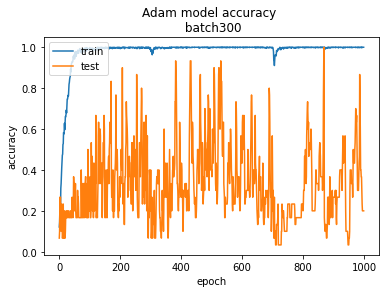

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Adam model accuracy \n batch300')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# 아담 그레이드 , 비아너리 -> 바이너리 크로스 / 이건 분류하는 거-> multi class categoty  예측하는 확률을 보여준다. 
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=8000,batch_size = 300, validation_data = (X_test, y_test),callbacks=[tb_callback])


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 40, 20)            134640    
_________________________________________________________________
lstm_10 (LSTM)               (None, 20)                3280      
_________________________________________________________________
batch_normalization_8 (Batch (None, 20)                80        
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                420       
_________________________________________________________________
batch_normalization_9 (Batch (None, 20)                80        
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)               

 -  모델의 결과 html 창으로 보기 
 - visualize the result of model



* cmd 창을 킨다 <br>

<br>
* C:\Users\User>cd Logs <br>
<br>
* C:\Users\User\Logs>cd Train<br>
<br>
* C:\Users\User\Logs\train>dir<br>

- 파일을 텐서플로우로 실행시킨다. (run the file )
* C:\Users\User\Logs\train>tensorboard --logdir=. 

- 링크를 복사하여 크롬창에 띄운다 ( copy the like and open it at Chrome)

# 예측하기 
8. Make Predictions

In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[3])]

'춥다'

In [ ]:
actions[np.argmax(y_test[3])]

'춥다'

# 모델 저장 
9. Save Weights

In [ ]:
#모델저장
model.save('trial_1000.h5')

In [ ]:
#모델 가중치 저장
#model.load_weights('trial1.h5')

# 모델 평가 
10. Evaluation using Confusion Matrix and Accuracy

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)
# 이원교차표 출력 

array([[[28,  0],
        [ 0,  2]],

       [[28,  0],
        [ 0,  2]],

       [[25,  0],
        [ 0,  5]],

       [[28,  0],
        [ 0,  2]],

       [[25,  0],
        [ 0,  5]],

       [[26,  0],
        [ 0,  4]],

       [[29,  0],
        [ 0,  1]],

       [[27,  0],
        [ 0,  3]],

       [[25,  0],
        [ 0,  5]],

       [[29,  0],
        [ 0,  1]]], dtype=int64)

In [ ]:
accuracy_score(ytrue, yhat)

1.0

# 실시간 예측하기 
11. Test in Real Time

In [ ]:
#모델 불러오기 
from tensorflow.keras.models import load_model

model = load_model('trial8000.h5')

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from scipy import stats

actions = np.array(['고치다','멈추다','춥다','고혈압', '저혈압','수술' ,'피곤하다','x-ray사진','충격','약'])

In [ ]:
import cv2
import sys
import time
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import numpy as np
import platform

def cv2_draw_label(image, text, point):
    x, y = point
    x, y = int(x), int(y)
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    font = 'malgun.ttf' 
    draw = ImageDraw.Draw(pil_image)
    try:
        imageFont = ImageFont.truetype(font, 30) #글자크기 
    except:
        imageFont = ImageFont.load_default()
    draw.text((x, y), text, font=imageFont, fill=(255,255,255))  # 글자 색깔 
    image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    return image



# 내가 고찬거 
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        cnt = 0

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        print(keypoints)
        sequence.append(keypoints)
        
        print(len(sequence))
        sequence = sequence[-40:] #마지막 30프레임
        print(len(sequence))
        if len(sequence) == 40: #30개차면 predict한다 
            res = model.predict(np.expand_dims(sequence, axis=0))[0] # 2차원을 3차원으로 늘려준다. [0]
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
   

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            #image = prob_viz(res, actions, image, colors)
        print(sentence)    
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        image = cv2_draw_label(image, ' '.join(sentence), (0,10))
        #cv2.putText(image, ' '.join('hello'), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49317878  0.58096695 -0.81166494 ...  0.          0.
  0.        ]
1
1
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49455032  0.57149798 -0.93734425 ...  0.          0.
  0.        ]
2
2
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49618202  0.56838065 -0.93817675 ...  0.          0.
  0.        ]
3
3
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49774987  0.56689626 -1.03606939 ...  0.          0.
  0.        ]
4
4
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49797139  0.56641221 -0.98941815 ...  0.          0.
  0.        ]
5
5
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49799919  0.56436151 -1.04380143 ...  0.          0.
  0.        ]
6
6
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49802893  0.56354529 -1.01773918 ...  0.          0.
  0.        ]
7
7
[]
<class 'mediapipe.python.solution_base.SolutionOutputs'

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49277037  0.56790751 -1.08853221 ...  0.31419444  0.37849221
 -0.02875343]
41
40
['x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49303526  0.56820309 -1.17284036 ...  0.          0.
  0.        ]
41
40
['x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.4930914   0.56953126 -1.17532337 ...  0.          0.
  0.        ]
41
40
['x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49315453  0.56942552 -1.06674159 ...  0.          0.
  0.        ]
41
40
['x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49365687  0.56926483 -1.01776493 ...  0.32177034  0.33595228
 -0.02683543]
41
40
['x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49672142  0.56819057 -1.05043972 ...  0.32597876  0.32004893
 -0.02680639]
41
40
['x-ray사진']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.49873534  0.56704873 -1.10437846 ...  0

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56096476  0.4682574  -1.14313281 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '충격']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56131482  0.46893379 -1.13933301 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '충격']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56158119  0.46887311 -1.13805842 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '충격']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56144035  0.46886799 -1.13120019 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '충격']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56162792  0.46913439 -1.16270292 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '충격']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56026673  0.46933231 -1.20243943 ...  0.          0.
  0.        ]
41
40
['x-ray사진', '충격']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.56005877  0.46948242 -1.230

In [ ]:
## open cv창 끄기 

cap.release()
cv2.destroyAllWindows()